In [1]:
import os
import glob
import pandas as pd
from tqdm.auto import tqdm
import time
import numpy as np
import numpy.ma as ma

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Read in the data to on dictionary of each Modal

In [2]:


sensor_list = ['act', 'acw', 'dc', 'pm']
# Test out the read in helper function
def get_subject_action(sensor, full_path):
    index = full_path.find(sensor)
    index += len(sensor)
    subject = int(full_path[index+1:index+3])
    action = int(full_path[index+4:index+6])
    if action == 4:
        if full_path.find(f"{sensor}_1") > 0:
            action = '4-1'
        else:
            action = '4-2'
        
    return (subject, str(action))

for sensor in sensor_list:
    for sensor_dir in glob.iglob('.\\data\\' + sensor ):
        print(f"On {sensor}")
        for subject_id, subject_dir in enumerate(glob.iglob(f"{sensor_dir}\\*")):
            for action_id, file in enumerate(os.listdir(subject_dir)):
                full_path = f"{subject_dir}\\{file}"
                #print(full_path, get_subject_action(sensor, full_path))
                
test_str = '.\\data\\act\\01\\01_act_1.csv'
get_subject_action('act', test_str)

On act
On acw
On dc
On pm


(1, '1')

In [3]:
%%time
total_data = {
    'act': None,
    'acw': None,
    'dc': None,
    'pm': None,
}


headers = {
    'act': ['times', 'X', 'Y', 'Z'],
    'acw': ['times', 'X', 'Y', 'Z'],
    'dc': ['times'],
    'pm': ['times']
}
for i in range(1,513):
    headers['pm'].append(f"sensor_{i}")
for i in range(1,193):
    headers['dc'].append(f"sensor_{i}")

actions = ['1', '2', '3', '4-1', '4-2', '5', '6', '7']

sensor_list = ['act', 'acw', 'dc', 'pm']
#sensor_list = ['acw']

# there are 956 files in our dataset
i = 0

pbar = tqdm(desc="load data", total=956)
for sensor in sensor_list:
    for sensor_dir in glob.iglob('.\\data\\' + sensor ):
        #print(f"On {sensor}")
        for subject_id, subject_dir in enumerate(glob.iglob(f"{sensor_dir}\\*")):
            for action_id, file in enumerate(os.listdir(subject_dir)):
                full_path = f"{subject_dir}\\{file}"
                df_tmp = pd.read_csv(full_path, names=headers[sensor])
                i+=1
                pbar.update(1)
                subject, action = get_subject_action(sensor, full_path)
                # add one to make it match the given format
                df_tmp['subject'] = subject
                df_tmp['action'] = action
                if total_data[sensor] is None:
                    total_data[sensor] = df_tmp
                else:
                    total_data[sensor] = pd.concat([total_data[sensor], df_tmp])

load data:   0%|          | 0/956 [00:00<?, ?it/s]

Wall time: 1min 56s


## Show what is in each

In [4]:
for key in total_data.keys():
    if total_data[key] is not None:
        print(key)
        print(total_data[key]['action'].unique())
        print(total_data[key]['subject'].unique())
        for header in headers[key]:
            if(total_data[key][header].isnull().values.any()):
                print(f"{header} has Null data")
        print(total_data[key].info())
        print('-------------------------------------------------------------------------')

act
['1' '2' '3' '4-1' '4-2' '5' '6' '7']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1400856 entries, 0 to 6418
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   times    1400856 non-null  object 
 1   X        1400856 non-null  float64
 2   Y        1400856 non-null  float64
 3   Z        1400856 non-null  float64
 4   subject  1400856 non-null  int64  
 5   action   1400856 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 74.8+ MB
None
-------------------------------------------------------------------------
acw
['1' '2' '3' '4-1' '4-2' '5' '6' '7']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313695 entries, 0 to 6013
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  -----

In [5]:
df_acw = total_data['acw']
subject = 1
action = '1'
df_acw[(df_acw.subject == subject) & (df_acw.action == action)]

,times,X,Y,Z,subject,action
0,2018-11-08 11:34:51.474000,0.125000,-0.046875,0.90625,1,1
1,2018-11-08 11:34:51.485000,0.109375,-0.062500,0.90625,1,1
2,2018-11-08 11:34:51.495000,0.109375,-0.062500,0.90625,1,1
3,2018-11-08 11:34:51.505000,0.125000,-0.062500,0.90625,1,1
4,2018-11-08 11:34:51.516000,0.125000,-0.062500,0.90625,1,1
...,...,...,...,...,...,...
6269,2018-11-08 11:35:56.373000,0.093750,-0.265625,0.87500,1,1
6270,2018-11-08 11:35:56.383000,0.093750,-0.281250,0.87500,1,1
6271,2018-11-08 11:35:56.394000,0.093750,-0.265625,0.87500,1,1
6272,2018-11-08 11:35:56.404000,0.093750,-0.265625,0.87500,1,1


In [6]:
total_data['pm'].head()

,times,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_505,sensor_506,sensor_507,sensor_508,sensor_509,sensor_510,sensor_511,sensor_512,subject,action
0,2018-11-08 11:34:51.468000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,68.0,77.0,55.0,193.0,387.0,331.0,125.0,6.0,1,1
1,2018-11-08 11:34:51.535000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,58.0,78.0,53.0,192.0,388.0,330.0,123.0,6.0,1,1
2,2018-11-08 11:34:51.602000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,64.0,78.0,53.0,195.0,390.0,330.0,119.0,7.0,1,1
3,2018-11-08 11:34:51.669000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,66.0,79.0,55.0,196.0,391.0,324.0,106.0,5.0,1,1
4,2018-11-08 11:34:51.737000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,64.0,79.0,55.0,194.0,391.0,321.0,114.0,6.0,1,1


In [7]:
# show reshape is doing what we think
x = np.array([[1,2,3],
          [4,5,6],
          [7,8,9],
          [10,11,12],
          [13,14,15],
          [16,17,18]])
y = np.array(range(0,24))
y = np.reshape(y, (6,4))

z = np.array(range(0,30))
z = np.reshape(z, (6, 5))


np.hstack((x,y,z))

array([[ 1,  2,  3,  0,  1,  2,  3,  0,  1,  2,  3,  4],
       [ 4,  5,  6,  4,  5,  6,  7,  5,  6,  7,  8,  9],
       [ 7,  8,  9,  8,  9, 10, 11, 10, 11, 12, 13, 14],
       [10, 11, 12, 12, 13, 14, 15, 15, 16, 17, 18, 19],
       [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29]])

In [8]:
%%time
# take the total dfs and make batches for each action each subject completed
# samples100 is how many samples should be in the 100HZ (the two accleromter data)
# samples15 is how many samples from the images should be take
subjects = range(1,31)
dc_X_cols = [f"sensor_{i}" for i in range(1,193)]
pm_X_cols = [f"sensor_{i}" for i in range(1,513)]
acw_X_cols = ["X", "Y", "Z"]

def batch_data(total_dfs, seconds=5):
    samples100 = 100*seconds
    samples15 = 15*seconds
    df_acw = total_dfs['acw']
    df_act = total_dfs['act']
    df_dc = total_dfs['dc']
    df_pm = total_dfs['pm']
    
    all_cols = []
    for i in range(0, samples100):
        all_cols += [f"acw_{val}_{i}" for val in acw_X_cols]
    for i in range(0, samples15):
        all_cols += [f"dc_{val}_{i}" for val in dc_X_cols]
    for i in range(0, samples15):
        all_cols += [f"pm_{val}_{i}" for val in pm_X_cols]
    for i in range(0, samples100):
        all_cols += [f"act_{val}_{i}" for val in acw_X_cols]
    
    
    df_all = pd.DataFrame(columns=all_cols+['action'])
    
    actions = df_acw['action'].unique()
    pbar = tqdm(desc="batch data", total=len(subjects)*len(actions))
    for subject in subjects:
        actions = df_acw['action'].unique()
        for action in actions:
            X_acw = df_acw[(df_acw.subject == subject) & (df_acw.action == action)][acw_X_cols].to_numpy()
            X_acw = X_acw[range(0, (X_acw.shape[0]//samples100)*samples100)] # cut off records that don't fit in the window
            X_acw = np.reshape(X_acw, (X_acw.shape[0]//samples100, samples100*len(acw_X_cols)))
            
            X_dc = df_dc[(df_dc.subject == subject) & (df_dc.action == action)][dc_X_cols].to_numpy()
            X_dc = X_dc[range(0, (X_dc.shape[0]//samples15)*samples15)]
            X_dc = np.reshape(X_dc, (X_dc.shape[0]//samples15, samples15*len(dc_X_cols)))
            
            X_pm = df_pm[(df_pm.subject == subject) & (df_pm.action == action)][pm_X_cols].to_numpy()
            X_pm = X_pm[range(0, (X_pm.shape[0]//samples15)*samples15)]
            X_pm = np.reshape(X_pm, (X_pm.shape[0]//samples15, samples15*len(pm_X_cols)))
            
            X_act = df_act[(df_act.subject == subject) & (df_act.action == action)][acw_X_cols].to_numpy()
            X_act = X_act[range(0, (X_act.shape[0]//samples100)*samples100)]
            X_act = np.reshape(X_act, (X_act.shape[0]//samples100, samples100*len(acw_X_cols)))
            
            # trim to the smallest one of these 4
            num_records = min(X_acw.shape[0], X_act.shape[0], X_pm.shape[0], X_dc.shape[0])
            X_acw = X_acw[range(0,num_records)]
            X_dc = X_dc[range(0,num_records)]
            X_pm = X_pm[range(0,num_records)]
            X_act = X_act[range(0,num_records)]
            
            X_total = np.hstack((X_acw, X_dc, X_pm, X_act))
            
            df_tmp = pd.DataFrame(X_total, columns=all_cols)
            df_tmp['action'] = action
            df_all = pd.concat([df_all, df_tmp])
            
            pbar.update(1)
            
    return df_all

df_batched = batch_data(total_data, seconds=3)
df_batched.head()

batch data:   0%|          | 0/240 [00:00<?, ?it/s]

Wall time: 1min 9s


,acw_X_0,acw_Y_0,acw_Z_0,acw_X_1,acw_Y_1,acw_Z_1,acw_X_2,acw_Y_2,acw_Z_2,acw_X_3,...,act_X_297,act_Y_297,act_Z_297,act_X_298,act_Y_298,act_Z_298,act_X_299,act_Y_299,act_Z_299,action
0,0.125000,-0.046875,0.906250,0.109375,-0.062500,0.906250,0.109375,-0.062500,0.906250,0.125000,...,-0.640625,-0.562500,0.437500,-0.656250,-0.562500,0.468750,-0.671875,-0.578125,0.468750,1
1,0.156250,-0.062500,0.906250,0.156250,-0.062500,0.890625,0.156250,-0.062500,0.890625,0.156250,...,-0.625000,-0.796875,0.171875,-0.625000,-0.781250,0.171875,-0.625000,-0.781250,0.171875,1
2,0.218750,-0.078125,0.890625,0.218750,-0.078125,0.875000,0.234375,-0.078125,0.890625,0.234375,...,-0.593750,-0.750000,0.281250,-0.609375,-0.750000,0.296875,-0.609375,-0.750000,0.296875,1
3,0.281250,-0.093750,0.859375,0.281250,-0.093750,0.875000,0.281250,-0.093750,0.859375,0.281250,...,-0.593750,-0.734375,0.296875,-0.593750,-0.734375,0.296875,-0.593750,-0.734375,0.296875,1
4,0.359375,-0.062500,0.843750,0.359375,-0.062500,0.843750,0.359375,-0.078125,0.843750,0.359375,...,-0.593750,-0.734375,0.312500,-0.578125,-0.734375,0.312500,-0.593750,-0.734375,0.296875,1


In [9]:
df_batched.groupby('action').count()

,acw_X_0,acw_Y_0,acw_Z_0,acw_X_1,acw_Y_1,acw_Z_1,acw_X_2,acw_Y_2,acw_Z_2,acw_X_3,...,act_Z_296,act_X_297,act_Y_297,act_Z_297,act_X_298,act_Y_298,act_Z_298,act_X_299,act_Y_299,act_Z_299
action,,,,,,,,,,,,,,,,,,,,,
1,419,419,419,419,419,419,419,419,419,419,...,419,419,419,419,419,419,419,419,419,419
2,447,447,447,447,447,447,447,447,447,447,...,447,447,447,447,447,447,447,447,447,447
3,449,449,449,449,449,449,449,449,449,449,...,449,449,449,449,449,449,449,449,449,449
4-1,226,226,226,226,226,226,226,226,226,226,...,226,226,226,226,226,226,226,226,226,226
4-2,198,198,198,198,198,198,198,198,198,198,...,198,198,198,198,198,198,198,198,198,198
5,427,427,427,427,427,427,427,427,427,427,...,427,427,427,427,427,427,427,427,427,427
6,398,398,398,398,398,398,398,398,398,398,...,398,398,398,398,398,398,398,398,398,398
7,441,441,441,441,441,441,441,441,441,441,...,441,441,441,441,441,441,441,441,441,441


# Stick the data into a net

In [10]:
seconds = 3
samples100 = 100*seconds
samples15 = 15*seconds

all_cols = []
for i in range(0, samples100):
    all_cols += [f"acw_{val}_{i}" for val in acw_X_cols]
for i in range(0, samples15):
    all_cols += [f"dc_{val}_{i}" for val in dc_X_cols]
for i in range(0, samples15):
    all_cols += [f"pm_{val}_{i}" for val in pm_X_cols]
for i in range(0, samples100):
    all_cols += [f"act_{val}_{i}" for val in acw_X_cols]

In [11]:
X = df_batched[all_cols].to_numpy()
X.shape

(3005, 33480)

In [12]:
df_y = pd.get_dummies(df_batched.action, prefix='action_ohe')
y = df_y.to_numpy()
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

### Train test split real quick

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [14]:
from tensorflow.keras.layers import Dense, Activation, Input, GRU, SimpleRNN, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform

def get_combined_model():
    input_all = Input(shape=(X.shape[1],))
    x = Dense(units=2048, activation='sigmoid',kernel_initializer='random_normal')(input_all)
    x = Dense(units=1024, activation='sigmoid',kernel_initializer='random_normal')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=512, activation='sigmoid',kernel_initializer='random_normal')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=512, activation='tanh',kernel_initializer='random_normal')(x)
    x = Dropout(0.3)(x)
    x = Dense(units=512, activation='tanh',kernel_initializer='random_normal')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=512, activation='tanh',kernel_initializer='random_normal')(x)
    prediction = Dense(units=8, activation='softmax')(x)

    model = Model(inputs=input_all, outputs=prediction)
    return model

In [20]:
from tensorflow.keras.optimizers import Adam
model = get_combined_model()
model.compile(optimizer=Adam(learning_rate=0.000001, beta_1=0.99, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 33480)]           0         
_________________________________________________________________
dense (Dense)                (None, 2048)              68569088  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656

In [21]:
%%time
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200,  batch_size=10)

Train on 2404 samples, validate on 601 samples
Epoch 1/200
2404/2404 [==============================] - 4s 2ms/sample - loss: 2.2966 - accuracy: 0.1202 - val_loss: 2.0902 - val_accuracy: 0.1281
Epoch 2/200
2404/2404 [==============================] - 4s 1ms/sample - loss: 2.2432 - accuracy: 0.1414 - val_loss: 2.0528 - val_accuracy: 0.1581
Epoch 3/200
2404/2404 [==============================] - 4s 1ms/sample - loss: 2.2284 - accuracy: 0.1373 - val_loss: 2.0418 - val_accuracy: 0.1797
Epoch 4/200
2404/2404 [==============================] - 4s 1ms/sample - loss: 2.2283 - accuracy: 0.1394 - val_loss: 2.0366 - val_accuracy: 0.1897
Epoch 5/200
2404/2404 [==============================] - 4s 1ms/sample - loss: 2.2322 - accuracy: 0.1406 - val_loss: 2.0302 - val_accuracy: 0.2180
Epoch 6/200
2404/2404 [==============================] - 4s 1ms/sample - loss: 2.2091 - accuracy: 0.1464 - val_loss: 2.0261 - val_accuracy: 0.2196
Epoch 7/200
2404/2404 [==============================] - 4s 1ms/sample 

2404/2404 [==============================] - 4s 2ms/sample - loss: 1.0143 - accuracy: 0.6364 - val_loss: 0.8811 - val_accuracy: 0.6988
Epoch 112/200
2404/2404 [==============================] - 4s 1ms/sample - loss: 1.0230 - accuracy: 0.6306 - val_loss: 0.8760 - val_accuracy: 0.6988
Epoch 113/200
2404/2404 [==============================] - 4s 1ms/sample - loss: 1.0361 - accuracy: 0.6215 - val_loss: 0.8715 - val_accuracy: 0.6972
Epoch 114/200
2404/2404 [==============================] - 4s 1ms/sample - loss: 1.0034 - accuracy: 0.6389 - val_loss: 0.8644 - val_accuracy: 0.7005
Epoch 115/200
2404/2404 [==============================] - 4s 1ms/sample - loss: 0.9904 - accuracy: 0.6601 - val_loss: 0.8578 - val_accuracy: 0.6988
Epoch 116/200
2404/2404 [==============================] - 4s 1ms/sample - loss: 0.9996 - accuracy: 0.6435 - val_loss: 0.8549 - val_accuracy: 0.6988
Epoch 117/200
2404/2404 [==============================] - 4s 1ms/sample - loss: 0.9925 - accuracy: 0.6394 - val_loss: 0

2404/2404 [==============================] - 3s 1ms/sample - loss: 0.6497 - accuracy: 0.7737 - val_loss: 0.6481 - val_accuracy: 0.7720
Epoch 167/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 0.6508 - accuracy: 0.7733 - val_loss: 0.6448 - val_accuracy: 0.7720
Epoch 168/200
2404/2404 [==============================] - 4s 1ms/sample - loss: 0.6584 - accuracy: 0.7816 - val_loss: 0.6423 - val_accuracy: 0.7737
Epoch 169/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 0.6387 - accuracy: 0.7800 - val_loss: 0.6380 - val_accuracy: 0.7787
Epoch 170/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 0.6409 - accuracy: 0.7804 - val_loss: 0.6345 - val_accuracy: 0.7837
Epoch 171/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 0.6489 - accuracy: 0.7837 - val_loss: 0.6322 - val_accuracy: 0.7787
Epoch 172/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 0.6220 - accuracy: 0.7928 - val_loss: 0

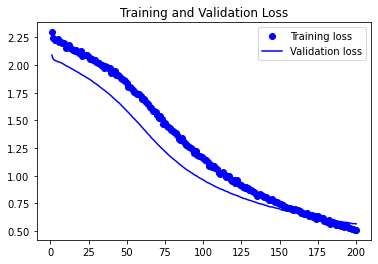

In [25]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [26]:


yhat = model.predict(X_train)
yhat = np.argmax(yhat, axis=1)
y_train_actual = np.argmax(y_train, axis=1)
print('Train:', accuracy_score(y_train_actual, yhat)*100)

yhat = model.predict(X_test)
yhat = np.argmax(yhat, axis=1)
y_test_actual = np.argmax(y_test, axis=1)
print('Validation:', accuracy_score(y_test_actual, yhat)*100)

Train: 90.68219633943427
Validation: 80.0332778702163


In [27]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

In [80]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

Fold 0
Train: 86.41810918774966
Validation: 76.72872340425532


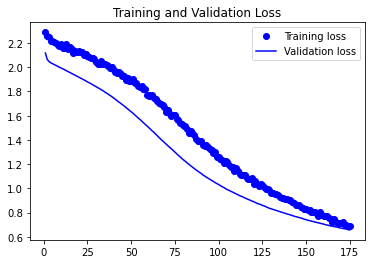

Fold 1
Train: 87.48890860692103
Validation: 79.22769640479362


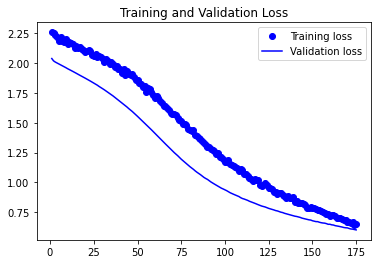

Fold 2
Train: 86.86779059449867
Validation: 74.30093209054593


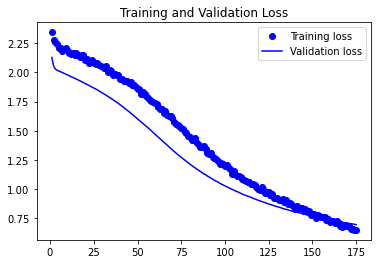

Fold 3
Train: 85.93611357586512
Validation: 77.3635153129161


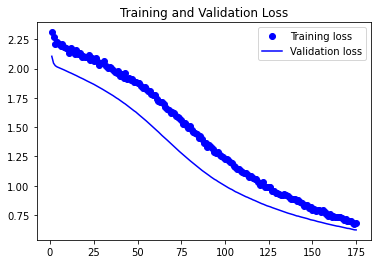

Wall time: 38min


In [30]:
%%time
folds = StratifiedKFold(n_splits=4, shuffle=True)
y_actual = np.argmax(y, axis=1)
for index, (train_indices, val_indices) in enumerate(folds.split(X, y_actual)):
    model = get_combined_model()
    # TODO: move this to the model def.
    model.compile(optimizer=Adam(learning_rate=0.000001, beta_1=0.99, beta_2=0.999),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(X[train_indices], y[train_indices],
                        validation_data=(X[val_indices], y[val_indices]),
                        epochs=175,  batch_size=10, verbose=False)
    yhat = model.predict(X[train_indices])
    yhat = np.argmax(yhat, axis=1)
    y_train_actual = np.argmax(y[train_indices], axis=1)
    print(f"Fold {index}")
    print('Train:', accuracy_score(y_train_actual, yhat)*100)

    yhat = model.predict(X[val_indices])
    yhat = np.argmax(yhat, axis=1)
    y_test_actual = np.argmax(y[val_indices], axis=1)
    print('Validation:', accuracy_score(y_test_actual, yhat)*100)
    
    plot_history(history)

In [32]:
# TODO: Change this to be saved from above.

vals = np.array([77.3635153129161, 74.30093209054593, 79.22769640479362, 76.72872340425532])
np.mean(vals)

76.90521680312774

# Lets play with making a multi modal model

In [101]:
df_batched.columns

Index(['acw_X_0', 'acw_Y_0', 'acw_Z_0', 'acw_X_1', 'acw_Y_1', 'acw_Z_1',
       'acw_X_2', 'acw_Y_2', 'acw_Z_2', 'acw_X_3',
       ...
       'act_X_297', 'act_Y_297', 'act_Z_297', 'act_X_298', 'act_Y_298',
       'act_Z_298', 'act_X_299', 'act_Y_299', 'act_Z_299', 'action'],
      dtype='object', length=33481)

In [121]:
# we have 300 different x,y,z's for each acc

#wrist data
acw_X_cols_batched = []
for j in range(0, samples100):
    acw_X_cols_batched += [f"acw_{val}_{j}" for val in acw_X_cols]
X_acw_batched = df_batched[acw_X_cols_batched].to_numpy()

# thigh data
act_X_cols_batched = []
for j in range(0, samples100):
    act_X_cols_batched += [f"act_{val}_{j}" for val in acw_X_cols]
X_act_batched = df_batched[acw_X_cols_batched].to_numpy()

# Depth Camera data
dc_X_cols_batched = []
for j in range(0, samples15):
    dc_X_cols_batched += [f"dc_{val}_{j}" for val in dc_X_cols]
X_dc_batched = df_batched[dc_X_cols_batched].to_numpy()
    
# Pressure Mat data
pm_X_cols_batched = []
for j in range(0, samples15):
    pm_X_cols_batched += [f"pm_{val}_{j}" for val in pm_X_cols]
X_pm_batched = df_batched[pm_X_cols_batched].to_numpy()
len(pm_X_cols_batched)

23040

## split for tuning


In [122]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_act_batched_train, X_act_batched_test, \
X_acw_batched_train, X_acw_batched_test, \
X_dc_batched_train, X_dc_batched_test, \
X_pm_batched_train, X_pm_batched_test, \
y_train, y_test = \
train_test_split(X_act_batched, X_acw_batched, X_dc_batched, X_pm_batched, y, 
                 test_size=0.2, shuffle=True)

print(X_act_batched_train.shape)
print(X_act_batched_test.shape)
print(X_acw_batched_train.shape)
print(X_acw_batched_test.shape)
print(X_dc_batched_train.shape)
print(X_dc_batched_test.shape)
print(X_pm_batched_train.shape)
print(X_pm_batched_test.shape)
print(y_train.shape)
print(y_test.shape)

(2404, 900)
(601, 900)
(2404, 900)
(601, 900)
(2404, 8640)
(601, 8640)
(2404, 23040)
(601, 23040)
(2404, 8)
(601, 8)


In [123]:
from tensorflow.keras.layers import concatenate

In [129]:
# https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
input_thigh = Input(shape=(X_act_batched.shape[1],))
input_wrist = Input(shape=(X_acw_batched.shape[1],))
input_dc = Input(shape=(X_dc_batched.shape[1],))
input_pm = Input(shape=(X_pm_batched.shape[1],))

# Build some layers for the thigh
thigh = Dense(512, activation="sigmoid")(input_thigh)
thigh = Dense(256, activation="sigmoid")(thigh)
thigh = Dropout(0.1)(thigh)
thigh = Dense(128)(thigh)
thigh = Model(inputs=input_thigh, outputs=thigh)

# Build some layers for the wrist
wrist = Dense(512, activation="sigmoid")(input_wrist)
wrist = Dense(256, activation="sigmoid")(wrist)
wrist = Dropout(0.1)(wrist)
wrist = Dense(128)(wrist)
wrist = Model(inputs=input_wrist, outputs=wrist)

# Build some layers for the depth camera
# but this time we will use conv2D
dc_tens = Dense(512, activation="sigmoid")(input_dc)
dc_tens = Dense(256, activation="sigmoid")(dc_tens)
dc_tens = Dropout(0.1)(dc_tens)
dc_tens = Dense(128)(dc_tens)
dc_tens = Model(inputs=input_dc, outputs=dc_tens)

# Build some layers for the pressure mat
pm_tens = Dense(512, activation="sigmoid")(input_pm)
pm_tens = Dense(256, activation="sigmoid")(pm_tens)
pm_tens = Dropout(0.1)(pm_tens)
pm_tens = Dense(128)(pm_tens)
pm_tens = Model(inputs=input_pm, outputs=pm_tens)


combined = concatenate([thigh.output, wrist.output, dc_tens.output, pm_tens.output])

# Now lets run some more dense layers
last = Dense(128, activation="tanh")(combined)
last = Dropout(0.3)(last)
last = Dense(64, activation="tanh")(combined)
prediction = Dense(units=8, activation='softmax')(last)

model = Model(inputs=[thigh.input, wrist.input, dc_tens.input, pm_tens.input], outputs=prediction)



In [130]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model_70"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_69 (InputLayer)           [(None, 900)]        0                                            
__________________________________________________________________________________________________
input_70 (InputLayer)           [(None, 900)]        0                                            
__________________________________________________________________________________________________
input_71 (InputLayer)           [(None, 8640)]       0                                            
__________________________________________________________________________________________________
input_72 (InputLayer)           [(None, 23040)]      0                                            
___________________________________________________________________________________________

In [132]:
history = model.fit(x=[X_act_batched_train, X_acw_batched_train, X_dc_batched_train, X_pm_batched_train],
                    y=y_train, 
                    validation_data=(
                        [X_act_batched_test,
                         X_acw_batched_test,X_dc_batched_test, X_pm_batched_test], y_test),
                    epochs=100,  batch_size=10)

Train on 2404 samples, validate on 601 samples
Epoch 1/100
2404/2404 [==============================] - 3s 1ms/sample - loss: 1.9350 - accuracy: 0.2745 - val_loss: 1.7566 - val_accuracy: 0.4193
Epoch 2/100
2404/2404 [==============================] - 1s 614us/sample - loss: 1.6443 - accuracy: 0.5025 - val_loss: 1.4796 - val_accuracy: 0.6556
Epoch 3/100
2404/2404 [==============================] - 1s 611us/sample - loss: 1.3999 - accuracy: 0.6290 - val_loss: 1.2714 - val_accuracy: 0.7271
Epoch 4/100
2404/2404 [==============================] - 1s 612us/sample - loss: 1.2210 - accuracy: 0.6855 - val_loss: 1.1011 - val_accuracy: 0.7504
Epoch 5/100
2404/2404 [==============================] - 1s 619us/sample - loss: 1.0522 - accuracy: 0.7363 - val_loss: 0.9697 - val_accuracy: 0.7820
Epoch 6/100
2404/2404 [==============================] - 1s 616us/sample - loss: 0.9242 - accuracy: 0.7725 - val_loss: 0.8664 - val_accuracy: 0.7837
Epoch 7/100
2404/2404 [==============================] - 1s 6

2404/2404 [==============================] - 1s 610us/sample - loss: 0.0230 - accuracy: 0.9983 - val_loss: 0.1409 - val_accuracy: 0.9551
Epoch 56/100
2404/2404 [==============================] - 1s 609us/sample - loss: 0.0212 - accuracy: 0.9983 - val_loss: 0.1414 - val_accuracy: 0.9617
Epoch 57/100
2404/2404 [==============================] - 1s 609us/sample - loss: 0.0197 - accuracy: 0.9988 - val_loss: 0.1371 - val_accuracy: 0.9584
Epoch 58/100
2404/2404 [==============================] - 1s 606us/sample - loss: 0.0195 - accuracy: 0.9992 - val_loss: 0.1355 - val_accuracy: 0.9567
Epoch 59/100
2404/2404 [==============================] - 1s 604us/sample - loss: 0.0178 - accuracy: 0.9992 - val_loss: 0.1416 - val_accuracy: 0.9534
Epoch 60/100
2404/2404 [==============================] - 1s 609us/sample - loss: 0.0166 - accuracy: 0.9996 - val_loss: 0.1352 - val_accuracy: 0.9584
Epoch 61/100
2404/2404 [==============================] - 1s 604us/sample - loss: 0.0149 - accuracy: 0.9996 - val

In [133]:
yhat = model.predict([X_act_batched_test, X_acw_batched_test, X_dc_batched_test])
yhat = np.argmax(yhat, axis=1)
y_test_actual = np.argmax(y_test, axis=1)
print('Validation:', accuracy_score(y_test_actual, yhat)*100)

plot_history(history)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 4 array(s), for inputs ['input_69', 'input_70', 'input_71', 'input_72'] but instead got the following list of 3 arrays: [array([[ 0.484375, -0.75    , -0.453125, ...,  0.5     , -0.765625,
        -0.375   ],
       [ 0.921875,  0.359375,  0.0625  , ...,  0.875   ,  0.390625,
         0.015625],
       [-0.09375 , -0.5...